In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, shutil
from keras import models
from keras import layers
from sklearn.metrics import confusion_matrix, f1_score
np.random.seed(123)
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [2]:
directory = 'Alzheimer_s Dataset/'

In [3]:
test_directory = 'Alzheimer_s Dataset/test/'
train_directory = 'Alzheimer_s Dataset/train/'

In [4]:
data_genorator = ImageDataGenerator(rescale=1./255,validation_split=0.2)

In [5]:
data_train= data_genorator.flow_from_directory( 
        train_directory, 
        subset= 'training',
        target_size=(224, 224), 
        batch_size = 4098, 
        seed = 123)

Found 4098 images belonging to 4 classes.


In [6]:
data_valid = data_genorator.flow_from_directory( 
        train_directory, 
        subset= 'validation',
        target_size=(224, 224), 
        batch_size = 1023, 
        seed = 123)

Found 1023 images belonging to 4 classes.


In [7]:
data_test= ImageDataGenerator(rescale=1./255).flow_from_directory( 
        test_directory, 
        subset= 'training',
        target_size=(224, 224), 
        batch_size = 1279, 
        seed = 123)

Found 1279 images belonging to 4 classes.


In [8]:
train_images, train_labels = next(data_train)

test_images, test_labels = next(data_test)

valid_images, valid_labels = next(data_valid)

In [9]:
def get_label(array):
    if array[0] ==1:
        return 0
    elif array[1] ==1:
        return 1
    elif array[2] ==1:
        return 2
    elif array[3] ==1:
        return 3

In [10]:
train_label_names = np.apply_along_axis(get_label,1,train_labels)

test_label_names = np.apply_along_axis(get_label,1,test_labels)

valid_label_names = np.apply_along_axis(get_label,1,valid_labels)

In [85]:
train_labels.shape

(4098, 4)

In [86]:
train_images.shape

(4098, 224, 224, 3)

In [87]:
x_train = train_images.reshape(4098,150528)

x_test = test_images.reshape(1279,150528)

x_valid = valid_images.reshape(1023,150528)



In [14]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam, SGD
from keras.metrics import Recall, Precision 

In [15]:
from imblearn.over_sampling import SMOTE

In [63]:
from keras.utils import to_categorical
import tensorflow as tf
from keras.callbacks import EarlyStopping

In [ ]:
batch_size = 15
num_classes = 4
epochs = 30


y_train = keras.utils.to_categorical(y_smote, num_classes)

y_valid = keras.utils.to_categorical(test_labels, num_classes)



model = Sequential()

model.add(Dense(30, activation='relu',input_shape=(150528,),use_bias=True,bias_initializer='zeros'))

model.add(Dense(30, activation='relu',use_bias=True,bias_initializer='zeros'))


model.add(Dense(num_classes, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer= Adam(),
              metrics=['accuracy',Recall()])

early_stop = EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='auto')

history = model.fit(x_train, train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks= [early_stop],
                    validation_data=(x_valid, valid_labels))
score = model.evaluate(x_test, test_labels, verbose=0)
print('test loss:', score[0])
print('Test recall:', score[2])
print('Test Accuracy', score[1])

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 30)                4515870   
_________________________________________________________________
dense_74 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_75 (Dense)             (None, 4)                 124       
Total params: 4,516,924
Trainable params: 4,516,924
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
 57/274 [=====>........................] - ETA: 42s - loss: 1.8062 - accuracy: 0.4749 - recall_23: 0.0608

In [57]:
print('Test Accuracy', score[1])

Test Accuracy 0.35027363896369934


In [73]:
import pickle

In [79]:
pickle_out = open('X_smote.pickle', 'wb')
pickle.dump(X_smote,pickle_out)
pickle_out.close()

In [81]:
pickle_out = open('y_smote.pickle', 'wb')
pickle.dump(y_smote,pickle_out)
pickle_out.close()

In [84]:
model.save('vanilla_model',save_format=tf)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: vanilla_model/assets


([0, 1, 2, 3], <a list of 4 Text major ticklabel objects>)

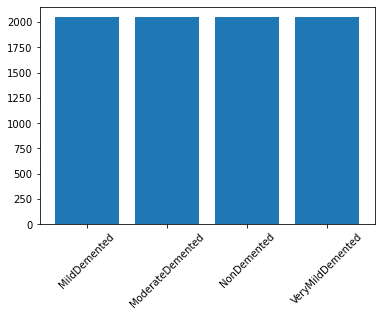

In [58]:
plt.bar(['MildDemented','ModerateDemented','NonDemented','VeryMildDemented'], sum(y_smote))
plt.xticks(rotation=45)

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

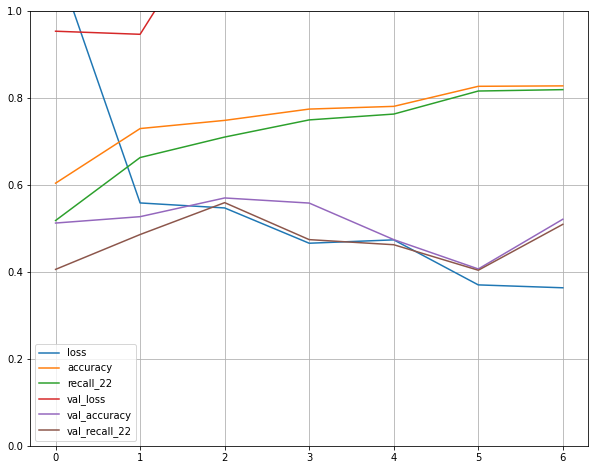

In [75]:
history_df = pd.DataFrame(history.history)
history_df.plot(figsize=(10,8))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [78]:
history_df.head(10)

,loss,accuracy,recall_22,val_loss,val_accuracy,val_recall_22
0,1.118261,0.603882,0.518066,0.953324,0.512219,0.405670
1,0.558446,0.729492,0.662842,0.946245,0.526882,0.485826
2,0.546953,0.748291,0.709961,1.254552,0.569892,0.559140
3,0.465803,0.774292,0.749390,1.046701,0.558162,0.474096
4,0.473568,0.780518,0.762817,1.162857,0.474096,0.462366
5,0.370003,0.826660,0.815796,1.783528,0.406647,0.403715
6,0.363354,0.827637,0.818970,1.051349,0.521017,0.509286


In [83]:
model